## IMPORT, SEED, CUDA
+ Import:

In [5]:
from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as Functional
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import os
from sklearn.utils import class_weight
import pandas as pd

+ GPU:

In [22]:
torch.cuda.set_device(0)
device = torch.device("cuda")
torch.cuda.is_available()

True

+ Seeds:

In [23]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(500)
    torch.cuda.manual_seed_all(500)

torch.manual_seed(500)

torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False


## Data
+ Datasets + data augmentation:

In [24]:
class ImagesDataset(torch.utils.data.Dataset):
    def __init__(self, csv_path, images_folder, transform = None):
        self.df = pd.read_csv(csv_path)
        self.images_folder = images_folder
        self.transform = transform
        self.class2index = {"side_view":0, "closeup":1, "non_match": 2, "front_view":3, "side_gate_view":4, "aerial_view":5, "wide_view":6}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        filename = self.df["basename"][index]
        label = self.class2index[self.df["category"][index]]
        image = torchvision.io.read_image(os.path.join(self.images_folder, filename))
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [25]:
from torchvision.transforms.transforms import ToPILImage
transform_orig = transforms.Compose(
    [
        transforms.ToPILImage(),
        transforms.ToTensor(),
        transforms.Resize(size=(360, 640)),
        transforms.Normalize(
            (0.3683047, 0.42932022, 0.29250222),
            (0.15938677, 0.16319054, 0.17476037),
        ),
    ])

transform_aug = transforms.Compose(
    [
     transforms.ToPILImage(),
     transforms.RandomRotation(25),
     transforms.Resize(size=(540,960)),
     transforms.RandomErasing(0.5),
     ])

In [26]:
dataset_no_aug = ImagesDataset(csv_path="../data/df_train_framefilter.csv", images_folder="../data/raw/train",transform=transform_orig)

In [ ]:
means = [[],[],[]]
stds = [[],[],[]]
it = 0
for img, _ in dataset_no_aug:
    means[0].append(torch.mean(img[0]))
    means[1].append(torch.mean(img[1]))
    means[2].append(torch.mean(img[2]))
    stds[0].append(torch.std(img[0]))
    stds[1].append(torch.std(img[1]))
    stds[2].append(torch.std(img[2]))
    it += 1
    if it == 10000:
        break


Counting each channel means and stdds to normalize data:

In [35]:
print(np.mean(means[0]),np.mean(means[1]),np.mean(means[2]))
print(np.mean(stds[0]),np.mean(stds[1]),np.mean(stds[2]))
# 0.3683047 0.42932022 0.29250222
# 0.15938677 0.16319054 0.17476037

0.3683047 0.42932022 0.29250222
0.15938677 0.16319054 0.17476037


In [3]:
cl = {"side_view":0, "closeup":1, "non_match": 2, "front_view":3, "side_gate_view":4, "aerial_view":5, "wide_view":6}

In [4]:
df = pd.read_csv("../data/df_train_framefilter.csv")
outs = map(lambda x: cl[x], list(df['category']))
outs = list(outs)

Class imbalance and class weights for loss function:

In [6]:
df['category'].value_counts()

side_view         6200
closeup           2812
non_match         1638
front_view         114
side_gate_view     109
aerial_view         67
wide_view           47
Name: category, dtype: int64

In [47]:
class_weights = class_weight.compute_class_weight("balanced",classes=np.unique(np.array(outs)), y=np.array(outs))

In [48]:
class_weights

array([ 0.25315668,  0.55816907,  0.95822432, 13.76817043, 14.39973788,
       23.42643923, 33.39513678])

+ Przykładowe obrazki:

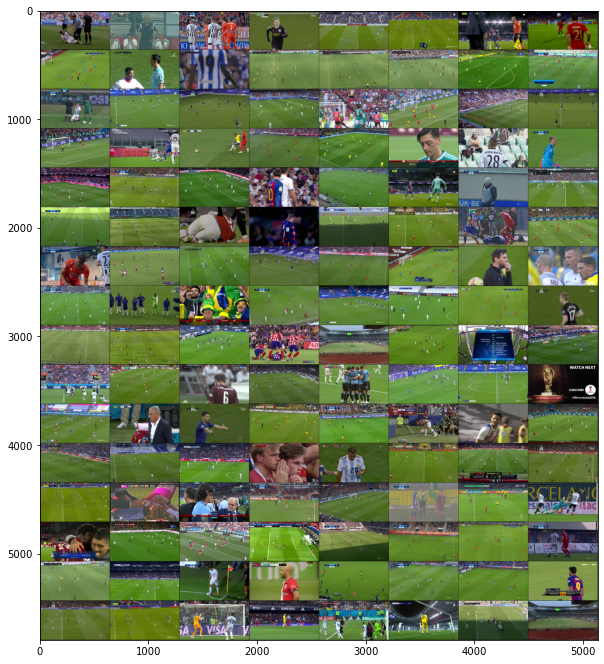

In [14]:
plt.figure(figsize=(10, 20))


def imshow(img):
    # img = img / 2 + 0.5
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

+ Klasy:

In [13]:
dataset_no_aug.class2index

{'side_view': 0,
 'closeup': 1,
 'non_match': 2,
 'front_view': 3,
 'side_gate_view': 4,
 'aerial_view': 5,
 'wide_view': 6}